In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DATA_PATH = 'data'

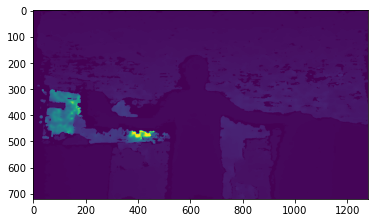

shape img:  (720, 1280)


In [3]:
imgs = []
for file_name in os.listdir(DATA_PATH):
    img_path = os.path.join(DATA_PATH, file_name)
    imgs.append(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY))
    
plt.imshow(imgs[0])
plt.show()

print('shape img: ', imgs[0].shape)

In [4]:
#Let us find the modes of the depth image here
import threading
import matplotlib.patches as patches

def g(x):
    return (3.0/4.0) * (1 - x * x) if np.abs(x) <= 1 else 0

def plot_img(img, x, y):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    circle = patches.Circle((x, y), radius=5, color='w')

    ax.add_patch(circle)
    #plt.show()

In [5]:
#https://saravananthirumuruganathan.wordpress.com/2010/04/01/introduction-to-mean-shift-algorithm/
img = imgs[0]
depth_hist = cv2.calcHist([img], [0], None, [256], [0, 256])
h = 0.5
epsilon = 1e-3

#Put this into a function
def generate_random_coords(x_bounds, y_bounds, seed):
    #np.random.seed(seed)
    offset = 50 #10 pixels
    return np.random.randint(offset, x_bounds - offset), np.random.randint(offset, y_bounds - offset)

def find_depth_centroid(img, h=0.1, epsilon=5e-2, seed=0):
    #Randomly assign centroids
    x_bounds = img.shape[1]
    y_bounds = img.shape[0]
    
    print(x_bounds)
    print(y_bounds)

    centroid_x, centroid_y = generate_random_coords(x_bounds, y_bounds, seed)
    
    count = 1
    is_stopped = False
    while not is_stopped:
        #print('count is ', count)
        count += 1
        
        #plot_img(img, centroid_x, centroid_y)
        
        #Find sub window
        d = 40 #20 pixels < 50 pixels
        x_start_win = centroid_x - d
        y_start_win = centroid_y - d
        x_end_win = centroid_x + d
        y_end_win = centroid_y + d

        window_y_bounds = 2 * d + 1
        window_x_bounds = window_y_bounds

        win = img[y_start_win : y_end_win, x_start_win : x_end_win]
        win_offset_in_y = y_start_win
        win_offset_in_x = x_start_win
        #print('window shape: ', win.shape)
        #print('window offset in x: ', win_offset_in_x)
        #print('window offset in y: ', win_offset_in_y)

        weighted_sum_x = 0.0
        weighted_sum_y = 0.0
        sum_of_weights = 0.0

        centroid_pixel_value = img[centroid_y][centroid_x]
        for row in range(0, window_y_bounds - 1):
            for col in range(0, window_x_bounds - 1):
                pixel_intensity = win[row][col]
                #distance measure L1 norm, Least Absolute Deviation (SUM|x_i - x_j|) or
                #L2 norm (SUM((x_i - x_j)^2)), Least Squares
                distance = ((centroid_pixel_value - pixel_intensity) * (centroid_pixel_value - pixel_intensity)) / (h * h)
                weight = g(distance)

                #center of mass of intensity (towards maximizing intensity gradient = mode)
                weighted_sum_x += (col + win_offset_in_x) * weight
                weighted_sum_y += (row + win_offset_in_y) * weight
                sum_of_weights += weight

        meanshift_x = int(weighted_sum_x / sum_of_weights)
        meanshift_y = int(weighted_sum_y / sum_of_weights)

        #Move the centroids towards the gradient ascend for the surroidning values
        centroid_x_prev = centroid_x
        centroid_y_prev = centroid_y
        
        #print('meanshift -> [{} {}]'.format(meanshift_x, meanshift_y))
        #print('centroids -> [{} {}]'.format(centroid_x, centroid_y))
        
        centroid_x = meanshift_x
        centroid_y = meanshift_y
        
        is_stopped = np.sqrt((centroid_x - centroid_x_prev) * (centroid_x - centroid_x_prev) + 
                             (centroid_y - centroid_y_prev) * (centroid_y - centroid_y_prev)) <= epsilon
        
    print('Converged!')
    return centroid_x, centroid_y

In [ ]:
class MyThread(threading.Thread):
    def __init__(self, group=None, target=None, name=None,
                 args=(), kwargs={}):
        threading.Thread.__init__(self, group, target, name, args, kwargs)
        self._return = None
        
    def run(self):
        threading.Thread.run(self)
            
    def join(self):
        threading.Thread.join(self)
        return self._return

workers = []
centroids = []
num_workers = len(imgs)
for idx in range(0, num_workers):
    name = 'th_' + str(idx)
    workers.append(MyThread(target=find_depth_centroid, name=name, args=(img, )))
    
for idx in range(0, num_workers):
    workers[idx].start()
    
count = num_workers
while count > 0:
    for idx in range(0, num_workers):
        if workers[idx].is_alive():
            centroids.append(workers[idx].join())
            count -= 1
        if count == 0: break
            
print('Waiting on threads...')

for idx in range(0, len(centroids)):
    x = centroids[idx][0]
    y = centroids[idx][1]
    print('x={} y={}'.format(x, y))
    print('pixel intensity= ', img[x][y])
    plot_img(img, x, y)
    
plt.show()

1280
720
1280
7201280
720



<ipython-input-5-40dcd1d90305>:58: RuntimeWarning: overflow encountered in ubyte_scalars
  distance = ((centroid_pixel_value - pixel_intensity) * (centroid_pixel_value - pixel_intensity)) / (h * h)


Converged!
Converged!
Converged!
